In this homework, you need to solve three tasks. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`).

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps

import scipy

%matplotlib inline

from sklearn.metrics.pairwise import rbf_kernel
from statsmodels.nonparametric.kernel_regression import KernelReg

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# Matplotlib settings
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter


#jupyterlab
#%matplotlib widget 

#jupyter-notebook
#%matplotlib notebook 

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

# Task 1. Model Selection (3 points)

In this task you will select model(choose set of covariates) using AIC criteria and forward/backward stepwise regression.

In [4]:
import numpy.linalg as nla

from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

Read the dataset from file 'pacn_wrcc.csv'. The target variable is `ly Solar Rad.`, others are covariates. Get X and Y matrices.

In [5]:
data = pd.read_csv('pacn_wrcc.csv')

y = np.array(data['ly Solar Rad.'])
cov = np.array(data[data.columns[data.columns != 'ly Solar Rad.']])
print(cov.shape, y.shape)

(300, 13) (300,)


Scale covariates to range `[0, 1]` and add bias column.

In [6]:
# YOUR CODE HERE
minmax_scaler = MinMaxScaler()
cov = minmax_scaler.fit_transform(cov) #scale to [0, 1]
X = np.c_[cov, np.ones(cov.shape[0])] #add bias column
X.shape

(300, 14)

### AIC and sample variance

Estimate sample variance of error with full set of covariates. Take into account number of dependent variables.

In [7]:
from statsmodels.regression.linear_model import OLS

model = OLS(y, X).fit()
pred = model.predict()

var1 = np.var(y - pred, ddof=X.shape[1])
var2 = np.sum((y - pred)**2) / (X.shape[0] - X.shape[1])
sigma2 = np.sqrt(var2)
print(var1, var2)

28.541679347084557 28.541679347084557


Implement estimate of AIC for given covariates, target and error variance.

In [8]:
def aic(X, y, sigma2=sigma2, alpha=0):
    model = OLS(y, X).fit()
    #AIC = model.aic, in this case minimization should be used
    
    AIC = model.llf - X.shape[1]
    
    #pred = model.predict()
    #AIC = -0.5*X.shape[0] * (np.log(2*np.pi) + np.log(sigma2**2)) - 0.5*np.sum((pred-y)**2)/sigma2**2 - X.shape[1] # for pure linear gaussian model
    return AIC

aic(X, y)

-935.2177782146889

### Forward stepwise regression

Implement forward stepwise regression. Save the order in which covariates are added to feature set and AIC values for those feature sets.

In [9]:
def diff(list1, list2):
    # only for case when list1 include list2
    return list(set(list1) - set(list2))

def forward_stepwise_regression(X, y, sigma2=sigma2, alpha=0.):
    cov_inds = list(np.arange(X.shape[1]))
    already_taken_cov_inds = []

    current_score = -np.inf
    memory = []
    
    while len(already_taken_cov_inds) < X.shape[1]:
        candidates = diff(cov_inds, already_taken_cov_inds)
        scores = []
        # find best next covar
        for next_cov_idx in candidates:
            current_cov_inds = already_taken_cov_inds.copy()
            current_cov_inds.append(next_cov_idx) 
            scores.append(aic(X[:, current_cov_inds], y))

        if max(scores) < current_score:
            #print('score does not improve, lets finish')
            break

        best = candidates[np.argmax(scores)]
        current_score = max(scores)
        already_taken_cov_inds.append(best)
        memory.append((best, current_score))
    
    return memory


memory = forward_stepwise_regression(X, y, sigma2=sigma2, alpha=0.)

names = list(data[data.columns[data.columns != 'ly Solar Rad.']].columns)
names.append('bias')

for cov_idx, aic_score in memory:
    print(f'Add {names[cov_idx]} column, AIC={round(aic_score,3)}')

Add Deg F Mx Air Temp column, AIC=-1141.151
Add % Rel Humidty column, AIC=-1033.102
Add volts Battery Voltage column, AIC=-1001.434
Add mph Mx Gust Speed column, AIC=-974.68
Add Deg F 4" Soil Ave Tmp column, AIC=-954.652
Add Deg F Av Air Temp column, AIC=-946.796
Add Deg F Mn Air Temp column, AIC=-936.349
Add Deg Wind Direc column, AIC=-935.843
Add Deg F 2" Soil Ave Tmp column, AIC=-935.703
Add Deg F 20"Soil Av Temp column, AIC=-932.012


### Backward stepwise regression

Implement backward stepwise regression. Save the order in which covariates are removed from feature set and AIC values for those feature sets.

In [10]:
def backward_stepwise_regression(X, y, sigma2=sigma2, alpha=0.):
    cov_inds = list(np.arange(X.shape[1]))
    already_dropped_cov_inds = []

    current_score = -np.inf
    memory = []  
    while X.shape[1] - len(already_dropped_cov_inds) > 1:
        candidates = diff(cov_inds, already_dropped_cov_inds)
        scores = []
        # find best next covar
        for next_cov_idx in candidates:
            current_cov_inds = diff(cov_inds, already_dropped_cov_inds)
            current_cov_inds.remove(next_cov_idx) 
            scores.append(aic(X[:, current_cov_inds], y))

        if max(scores) < current_score:
            #print('score does not improve, lets finish')
            break

        best = candidates[np.argmax(scores)]
        current_score = max(scores)
        already_dropped_cov_inds.append(best)
        memory.append((best, current_score))
    
    return memory

memory = backward_stepwise_regression(X, y, sigma2=sigma2, alpha=0.)

names = list(data[data.columns[data.columns != 'ly Solar Rad.']].columns)
names.append('bias')

for cov_idx, aic_score in memory:
    print(f'Remove {names[cov_idx]} column, AIC={round(aic_score,3)}')

Remove mph Wind Speed column, AIC=-934.236
Remove Deg F 8" Soil Av Temp column, AIC=-933.364
Remove Deg Dir MxGust column, AIC=-932.703
Remove bias column, AIC=-932.012


### Bruteforce

Find best sets of covariates and their AIC for all sizes of feature sets.

In [11]:
from functools import reduce
def powerset(lst):
    return reduce(lambda result, x: result + [subset + [x] for subset in result], lst, [[]])

def bruteforce(X, y, sigma2=sigma2, alpha=0.):
    bruteforce_combinations = powerset(np.arange(X.shape[1]))
    bruteforce_combinations = bruteforce_combinations[1:] #throw away empty subset

    scores = []
    for current_cov_inds in bruteforce_combinations:
        scores.append(aic(X[:, current_cov_inds], y))
        
    return bruteforce_combinations[np.argmax(scores)], max(scores)

best_combination, aic_score = bruteforce(X, y, sigma2=sigma2)

names = list(data[data.columns[data.columns != 'ly Solar Rad.']].columns)
names.append('bias')
names = np.array(names)

print(f'{names[best_combination]} columns, AIC={round(aic_score,3)}')

['Deg Wind Direc' 'Deg F Av Air Temp' '% Rel Humidty'
 'volts Battery Voltage' 'mph Mx Gust Speed' 'Deg F Mn Air Temp'
 'Deg F Mx Air Temp' 'Deg F 2" Soil Ave Tmp' 'Deg F 4" Soil Ave Tmp'
 'Deg F 20"Soil Av Temp'] columns, AIC=-932.012


Write your conclusions about conducted experiments.

Each of the three regression methods achieves one level of AIC ~ $-932.012$.
Interestingly, the set of features on which the best value is achieved is not unique (with some numerical precision).
The full bruteforce method (by design) selects the best feature set yet has unacceptable complexity when the number of features is large ($\gg14$).
In our case, backward stepwise regression turns out to be optimal in terms of a number of iterations, but I don't think that this conclusion would hold for other datasets.

# Task 2. Local regression (3 points)

In [12]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt

#%matplotlib inline

You are given a sample of pairs $(X_i, Y_i)$. The output variable appers to be binary. We know a model for this type of data: logistic regression. In this model we assume the log-odds of the Bernoulli output variable to be a linear function:
$$\mathbb{P}(Y_i = 1 | X_i = x_i) = p(x_i) = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$$

In [13]:
X = np.array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18181818,
        1.24242424,  1.3030303 ,  1.36363636,  1.42424242,  1.48484848,
        1.54545455,  1.60606061,  1.66666667,  1.72727273,  1.78787879,
        1.84848485,  1.90909091,  1.96969697,  2.03030303,  2.09090909,
        2.15151515,  2.21212121,  2.27272727,  2.33333333,  2.39393939,
        2.45454545,  2.51515152,  2.57575758,  2.63636364,  2.6969697 ,
        2.75757576,  2.81818182,  2.87878788,  2.93939394,  3.        ])

In [14]:
Y = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

Lets fit a standard logistic regression to the data:

In [15]:
logreg = LogisticRegression(solver='newton-cg', penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

Coefficients of the fitted logistic regression model: b0=0.3769888804327461, b1=0.910931762183964


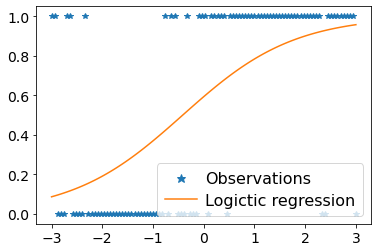

In [17]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.legend()

## Local regression

As we can see, the dependence of the outcome on $x$ looks more complex than estimated using logistic regression. We will try to improve it with local regression methods instead.
Instead of a global model, we will approximate conditinal probability of the positive class in a neighbourhood of $x$ with:
$$p(u) \approx \frac{e^{\beta_0 + \beta_1 (u-x) }}{1 + e^{\beta_0 + \beta_1 (u-x)}}, $$
for $u$ close to $x$. The coefficients in this case will depend on $x$. To find them, we will have to fit a (slightly different) model at each new query point $x_{new}$ (point where we want to predict $Y$). We will also need to introduce a notion of 'closenes' of points across $x$ - for this we can use our familiar *kernel functions*. Bringing everything together, we introduce the following local loglikelihood for our proposed model:
$$\ell_x(\beta) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right)\ell\left(Y_i, \beta_0 + \beta_1 \left(X_i - x\right)\right) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right) \left(Y_i \left(\beta_0 + \beta_1 \left(X_i - x\right)\right) - \log \left( 1 + e^{\beta_0 + \beta_1 \left(X_i - x\right)} \right) \right),$$
$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$
Here $\ell(y, z)$ is a log-likelohood for a single Bernoulli with log-dds ratio $z = \frac{p}{1-p}$. The local log-likelihood $\ell_x(\beta)$ should be optimized numerically to each new point $x$ to obtain $\widehat{\beta}(x)=(\widehat{\beta_0}(x), \widehat{\beta_1}(x))$. Then, we can predict $Y$ using the logistic model:
$$ \mathbb{P}(Y=1 | X=x) = \frac{e^{\beta_0(x)}}{1 + e^{\beta_0(x)}}.$$
Your task is:
1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package
2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample
3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth
4. Summarize your findings

In [18]:
# 1.Implement the proposed local logistic regression approach using Gaussian kernel.
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator
import scipy

class LocalLogisticRegression(BaseEstimator):
    def __init__(self, bandwidth=1):
        self.bandwidth = bandwidth
        
    def get_params(self, deep=True):
        return {"bandwidth": self.bandwidth}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, X, Y, beta_init=(0.3769, 0.9109)):
        self.X_train = X
        self.Y_train = Y
        self.beta_init = beta_init
        
    def kernel(self, shift):
        return np.exp(-shift**2 / (2 * self.bandwidth)) / np.sqrt(2*np.pi)
    
    def neg_llh(self, beta, x):
        llh = 0
        for i in range(self.X_train.shape[0]):
            shift = self.X_train[i] - x
            z = beta[0] + beta[1] * shift
            z = np.clip(a = z, a_min = 0., a_max = 500) # clip to avoid exponent overflow
            llh += self.kernel(shift) * (self.Y_train[i]*z - np.log(1 + np.exp(z)))
        return -llh
       
    def predict_proba(self, x, method='weight'):
        if method == 'direct':
            # In this case an explicit numerical optimization of LLH is implemented.
            # There may be problems with exponent overflow and instability of the numerical optimization method.
            beta = scipy.optimize.minimize(self.neg_llh, x0=self.beta_init, args=(x)).x
        elif method == 'weight':
            # In this case kernel weights are used in classic logreg.
            # This way is more stable and fast.
            shifts = self.X_train - x
            kernel_weights = self.kernel(shifts)
            
            logreg = LogisticRegression(solver='newton-cg', penalty='none')
            logreg.fit(shifts.reshape(-1, 1), self.Y_train, sample_weight = kernel_weights) 
            beta = (logreg.intercept_[0], logreg.coef_[0][0])
        else:
            raise NotImplemented
            
        p = 1 / (1 + np.exp(-beta[0]))
        return p
    
loclogreg = LocalLogisticRegression(1.)
loclogreg.fit(X, Y)
loclogreg.predict_proba(1.)

0.9097244809051008

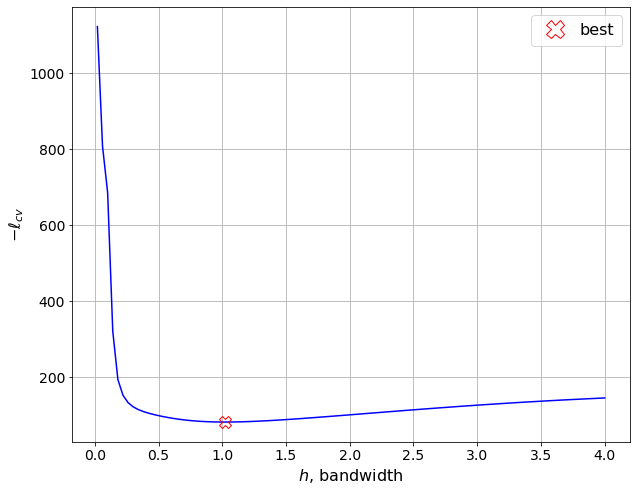

In [19]:
# 2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation.
def neg_llh_odds_scorer(model, x, y):
    # custom scorer function
    p = model.predict_proba(x)
    z = p/(1. - p) 
    z = np.clip(a = z, a_min = 0., a_max = 500) # clip to avoid exponent overflow
    llh = y * z - np.log(1 + np.exp(z))
    return -llh

loo = LeaveOneOut()
bandwidth_set = np.linspace(0.02, 4, 100)
scores_set = []
for bandwidth in bandwidth_set:
    loclogreg = LocalLogisticRegression(bandwidth)
    score = cross_val_score(loclogreg, X, Y, cv=loo, scoring=neg_llh_odds_scorer).sum()
    scores_set.append(score)

optimal_bandwidth = bandwidth_set[np.argmin(scores_set)]

plt.figure(figsize=(10, 8))
plt.plot(bandwidth_set, scores_set, 'b')
plt.plot([optimal_bandwidth], [min(scores_set)], 'rX', ms=12, fillstyle='none', label='best')
plt.ylabel('$-\ell_{cv}$')
plt.xlabel('$h$, bandwidth')
plt.legend()
plt.grid()
plt.show()

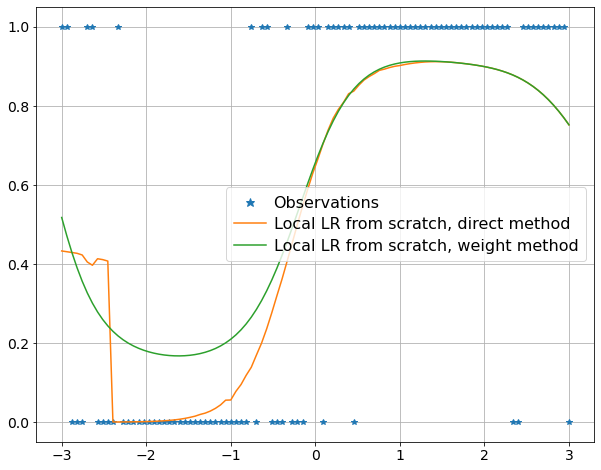

In [20]:
loclogreg = LocalLogisticRegression(optimal_bandwidth)
loclogreg.fit(X, Y)
plt.figure(figsize=(10, 8))
plt.plot(X, Y, '*', label='Observations')

predictions = np.array([loclogreg.predict_proba(x, method='direct') for x in X])
plt.plot(X, predictions, label='Local LR from scratch, direct method')

predictions = np.array([loclogreg.predict_proba(x, method='weight') for x in X])
plt.plot(X, predictions, label='Local LR from scratch, weight method')

plt.grid()
plt.legend()
plt.show()

# Both methods behave better than conventional global logistic regression and are similar to each other to some extent.
# However, the direct method behaves oddly (x from -3 to -1), most likely due to the instability of the numerical method.
# The weight method is much faster and more stable than the direct method.

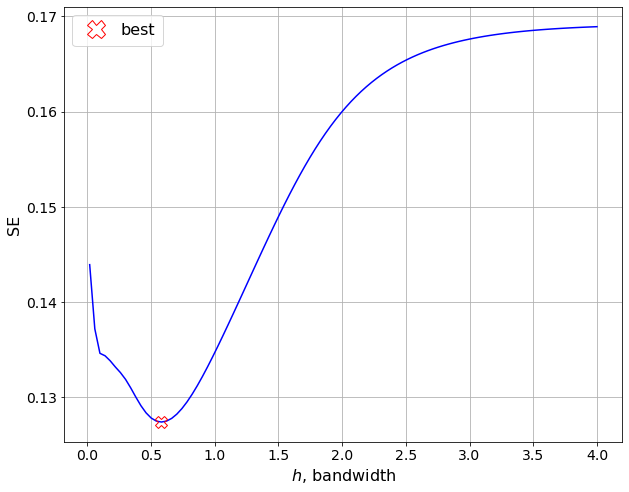

In [21]:
# 3. Now ignore that the output variable is binary. 
# Compare previous results with local linear kernel regression method using KernelReg from statsmodels. 
# Use leave-one out squared error cross-validation to select the bandwidth.

loo = LeaveOneOut()

bandwidth_set = np.linspace(0.02, 4, 100)
scores_set = []
for bandwidth in bandwidth_set:
    score = 0
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        kernel_reg = KernelReg(Y_train, X_train, var_type='c', bw=[bandwidth])
        prediction = kernel_reg.fit(X_test)[0]
        score += (Y_test - prediction)**2
        
    scores_set.append(score/(X.size - 1))
    
optimal_bandwidth = bandwidth_set[np.argmin(scores_set)]

plt.figure(figsize=(10, 8))
plt.plot(bandwidth_set, scores_set, 'b')
plt.plot([optimal_bandwidth], [min(scores_set)], 'rX', ms=12, fillstyle='none', label='best')
plt.ylabel('SE')
plt.xlabel('$h$, bandwidth')
plt.legend()
plt.grid()
plt.show()

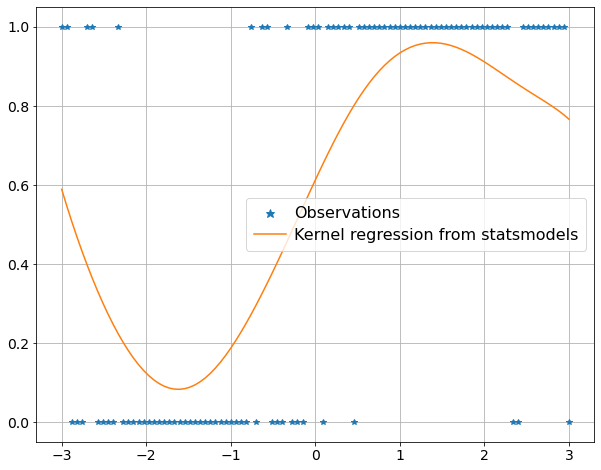

In [22]:
kernel_reg = KernelReg(Y, X, var_type='c', reg_type='ll', bw=[optimal_bandwidth])
prediction = kernel_reg.fit()[0]
plt.figure(figsize=(10, 8))
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, prediction, label='Kernel regression from statsmodels')

plt.grid()
plt.legend()
plt.show()

In [23]:
#4. Both methods (from scratch and kernel regression) give similar results. 
#They outperform classical global logistic regression and capture a more complex pattern in the data. 
#Additional comments (e.g., that it is necessary to take into account the possible instability of numerical optimization methods) can be found in the code above.

## Task 3. Bayesian inference with MCMC (4 points)

In [24]:
import numpy as np
import scipy
import scipy.stats

import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

#%matplotlib inline

from tqdm.auto import tqdm

We will consider a simple case of Bayesian inference for the unknown mean parameter of a Normal distribution. A series of values $\boldsymbol{X}^{(n)} = X_1, X_2, \dots X_n$ is sampled **independently** from a Normal distribution and we know its variance in advance, but are unsure about the mean. We assign a prior distribution to this unknown mean and would like to infer its posterior. We are also interested in predicting future observations $X$, so we would like to obtain its posterior predictive distribution as well.
$$\mu \sim \mathcal{N}(\mu_0, \sigma_0^2)$$
$$X_i | \mu \sim \mathcal{N}(\mu, \sigma^2), \; i=1 \dots n.$$

In [25]:
np.random.seed(31337)

true_mu = 3.0
true_std = 0.3
N = 20

prior_mu = 0.
prior_std = 1.

X = np.random.normal(true_mu, true_std, 20)

### Task 3.1: implement analytical posterior (0.5 points)

$$p(\mu | \boldsymbol{X}^{(n)}) = \frac{p(\boldsymbol{X}^{(n)} | \mu) p(\mu)}{p(\boldsymbol{X}^{(n)})}, \label{eq1} \tag{1}$$
$$p(\boldsymbol{X}^{(n)}) = \int p(\boldsymbol{X}^{(n)}, \mu) d\mu$$
For our simple case it is actually possible to derive the exact posterior distibution of the mean analytically. Posterior distiribution of $\mu$ will also be Normal, but with different parameters that will depend on the observed sample and prior parameters. Refer to https://en.wikipedia.org/wiki/Conjugate_prior for the exact formulas and implement them in the following function:

Posterior hyperparameters of $\mu$ are as follows:
$$
\mu_p = \left(\dfrac{1}{\sigma_0^2} + \dfrac{N}{\sigma^2}\right)^{-1}
\left(\dfrac{\mu_0}{\sigma_0^2} + \dfrac{\sum_{i=1}^{N} X_i}{\sigma^2}\right)
\quad \& \quad
\sigma_p^2 = \left(\dfrac{1}{\sigma_0^2} + \dfrac{N}{\sigma^2}\right)^{-1}.
$$

In [26]:
def analytical_posterior_pdf(x, samples, sigma, mu_0, sigma_0):
    """
    Probability density of the analytical posterior for the Normal model with known variance
    
    :param x: point(s) where to evaluate the density
    :param samples: observed samples
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p(mu | samples)(x)
    """
    
    sigma_p = np.sqrt((1./sigma_0**2 + samples.size/sigma**2)**(-1))
    mu_p = (mu_0/sigma_0**2 + np.sum(samples)/sigma**2) * sigma_p**2
        
    return scipy.stats.norm(mu_p, sigma_p).pdf(x)

Plot the resulting analytical posterior for the given observed sample, standard deviation of $X_i$ and prior parameters.

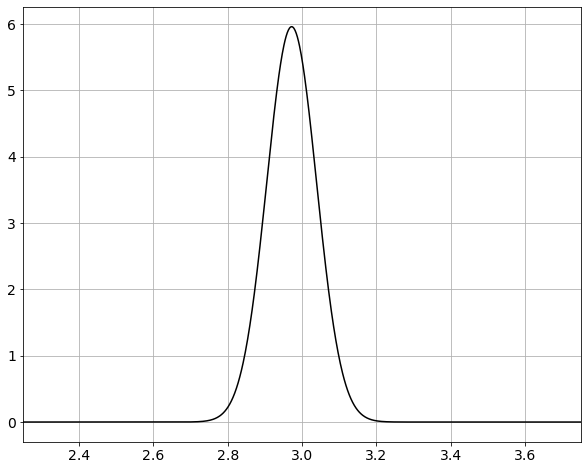

In [27]:
x_p = np.linspace(0.75*true_mu, 1.25*true_mu, 1000)

plt.figure(figsize=(10, 8))
plt.plot(x_p, analytical_posterior_pdf(x_p, X, true_std, prior_mu, prior_std), 'k-')
plt.xlim(0.75*true_mu, 1.25*true_mu)
plt.grid()
plt.show()

### Task 3.2: Metropilis-Hastings algorithm (2 points)

In more complex models it is usually infeasible to derive the exact formula for the posterior density. In the equation (1), the numerator contains easy to evaluate terms: prior and likelihood, while the denominator is rather hard to find. This means that we know our posterior only up to a constant multiplicative term. We will have to resort to approximations. Previously in the course we have studied methods to estimate the unknown density from samples. If we could sample from this unknown posterior, we might be able to approximate it using a histogram or a kernel method.

This is precisely the goal of MCMC methods. We will construct a Markov chain that will eventually produce samples from our distribution of interest - the posterior.


Markov chain is a sequence of random variables $Y_1, Y_2, \dots$ with the following property:
$$p(Y_k | Y_{k-1}, Y_{k-2}, \dots, Y_2, Y_1) = p(Y_k | Y_{k-1}),$$
wich means that subsequent values ($Y_k$) do not depend on the whole history of the sequence if the previous value ($Y_{k-1}$) is given.

We want to start with our chain from the prior distribution $Y_1 \sim p(\mu)$ and eventually converge to the posterior $Y_k \sim p(\mu | \boldsymbol{X}^{(n)})$. In order to achieve this, we need to define the transition probabilities $p(Y_k | Y_{k-1})$ in a special way. Intuitevely, it will depend on the prior and posterior in some way and there may be different possibilities.

We will describe one way to do it, namely Metropilis-Hastings algorithm with a random walk proposal. It was introduced in lecture 10, slides 19-22. We will use it to draw a sequence of samples from a special markov chain that satisfies our requirements.

Let $T$ be the number of steps we decided to take from the chan. For our example model and using our notation the algorithm outilines as follows:

1. Start by sampling $Y_1$ from the prior $p(\mu)$
2. Repeat for each $k$ form 1 to T:
3. Construct the next sample $Y_{k+1}$ given the previous sampled value $Y_k$:
4. $Y_{k+1} = Y_{k} + Z_{k+1}$, where $Z_{k+1} \sim \mathcal{N}(0, \sigma_{step}^2)$ (we take a sample)
5. We need to decide whether to make the transition $Y_k \rightarrow Y_{k+1}$ (accept or reject our *proposed* new value $Y_{k+1}$):
6. Accept the new sample with probability $\min \left\{1, \frac{p(\boldsymbol{X}^{(n)} | \mu = Y_{k+1}) p(\mu = Y_{k+1})}{p(\boldsymbol{X}^{(n)} | \mu = Y_{k}) p(\mu = Y_{k})}\right\}$, otherwise let $Y_{k+1} = Y_k$

Notice that our acceptance probability equals the ratio of the **posterior** probabilities: $\frac{p(\mu=Y_{k+1} | \boldsymbol{X}^{(n)})}{p(\mu=Y_k | \boldsymbol{X}^{(n)})}$, since the denominator in formula (1) does not depend on $\mu$. This allows us to skip the hard part of taking the integral. 

Your task is to implement these steps, including the calculation of the acceptance probability, and run the chain. Numpy array `Y` should contain one MCMC trajectory that you have obtained as the result.

*You may need to tune the $\sigma_{step}$ parameter.

In [28]:
def acceptance_prob(y_new, y_old, samples, sigma, mu_0, sigma_0):
    """
    Calculate acceptance probability in Metropilis-Hastings step for the Normal model with known variance
    :param y_new: proposed value (corresponds to Y_{k+1})
    :param y_old: previous value (corresponds to Y_k)
    :param samples: observed data (X^(n))
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p, acceptance probability
    """

    posterior_ynew = np.prod(scipy.stats.norm(y_new, sigma).pdf(samples))
    posterior_yold = np.prod(scipy.stats.norm(y_old, sigma).pdf(samples))
    prior_ynew = scipy.stats.norm(mu_0, sigma_0).pdf(y_new)
    prior_yold = scipy.stats.norm(mu_0, sigma_0).pdf(y_old)
    
    r = (posterior_ynew * prior_ynew) / (posterior_yold * prior_yold)
    p = min(1., r)
    return p

In [29]:
T = 2000

sigma_step = 0.1

Y = np.empty(T)
alphas = np.empty(T)

Y[0] = np.random.normal(prior_mu, prior_std)

for i in tqdm(range(1, T)):
    
    # To be honest, changing the variance did not produce a major change in the results.
    if i%500==0 and i>200:
        sigma_step *= 0.75
        
    Z = scipy.stats.norm(0, sigma_step).rvs(size=1)[0]
    Y_next = Y[i-1] + Z
    
    alphas[i] = acceptance_prob(Y_next, Y[i-1], X, true_std, prior_mu, prior_std)
    if np.random.random() < alphas[i]:
        Y[i] = Y_next
    else:
        Y[i] = Y[i-1]

### Task 3.3: Visualize the results (0.5 point)
We have obtained a single trajectory of our Markov chain. The starting portion the obtained values may be different from the samples of the actual posterinir. After the so-called 'burn-in' or 'warmup' phase the distribution should become stationary and connverge to the true posterior. Time spent before this convergence occurs is usually called *mixing time*, and it is hard to estimate in practical situations.

1. Plot your trajectory using line chart: x-axis will be the timestep number and y-axis the sampled value

2. Plot the acceptance probability: how many proposed steps were accepted on average at given timestep (use sliding window or exponential moving average). Does it change over time? (You may need to save additional info during sampling in the previous part)

3. When do you think the 'mixing' occured? (Approximately)

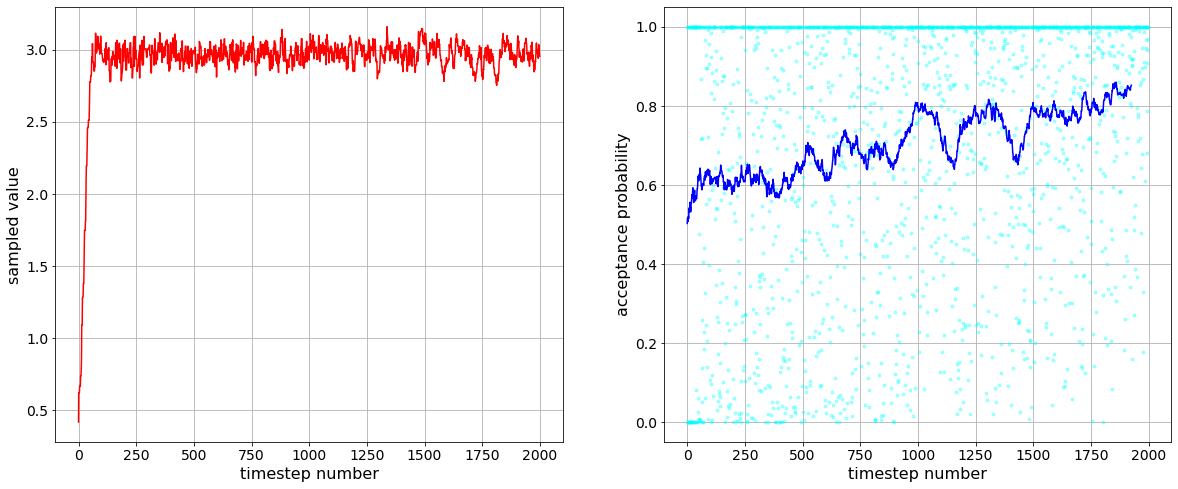

In [30]:
def moving_average(x, d):
    return 1./d * np.convolve(x, np.ones(d), 'valid')

plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylabel('sampled value')
plt.xlabel('timestep number')
plt.plot(Y, 'r-')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(alphas, 'o', ms=3, color='cyan', alpha=0.3)
plt.plot(moving_average(alphas, 75), 'b-')
plt.ylabel('acceptance probability')
plt.xlabel('timestep number')
plt.grid()
plt.show()

# The average acceptance probability value changes over time generally due to changes in sigma_step, so we see some trend in the acceptance probability.
# The rest of the effects can be attributed to noise or the learning process.
# 
# Apparently, mixing occurred when we reach the stationary probability value of the Markov chain. 

### Task 3.4: Approximate posterior (1 points)

Now we have determined the part of our trajectory that converged to our target distribution (you can use your guess from the previous task or just designate first half the trajectory for mixing). We will work with the remaing part to approximate the posterior.

1. Plot the histogram and kernel density estimator of the posterior using the samples from your MCMC run
2. Unfortunately, the samples that we obtained are not independent: due to the nature of our proposal step they are correlated. We can try to aleviate this effect by dropping some of the samples. Use only every 3rd (or 4th, 5th) obtained sample from the chain and display the corresponding distribution estimate on the same plot. Is it different?
3. Add theoretical posterior from part 1 to the same plot. Is it close to our estimate(s)?

In [31]:
# Some of the code in this cell is brazenly taken from the seminar_06.

def create_binedges(center, bandwidth, x_left, x_right):
    h = bandwidth
    bins = [center - h / 2]
    while x_left <= bins[-1]:
        bins.append(bins[-1] - h)
    bins = list(reversed(bins))
    while x_right >= bins[-1]:
        bins.append(bins[-1] + h)
    return bins

def histogram_pdf_estimated_risk(bincounts, bandwidth):
    h = bandwidth
    n = np.sum(bincounts)
    ps = bincounts / n
    return 2. / ((n - 1) * h) - ((n + 1.0) / (h * (n - 1.0))) * np.sum(ps ** 2)

def hist_wrapper_full(samples):
    bandwidth_range = np.linspace(0.00001, 0.1, 1000)
    risk_values = []
    for bandwidth in bandwidth_range:
        binedges = create_binedges(0, bandwidth, samples.min(), samples.max())
        bincounts, _ = np.histogram(samples, bins=binedges)
        risk_values.append(histogram_pdf_estimated_risk(bincounts, bandwidth))
    risk_values = np.array(risk_values)

    index_min = np.argmin(risk_values)
    opt_bandwidth = bandwidth_range[index_min]
    min_risk = risk_values[index_min]
    
    """
    print('h = {}, J = {}'.format(opt_bandwidth, min_risk))
    plt.figure(figsize=(10, 8))
    plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2)
    plt.axvline(opt_bandwidth)
    plt.legend()
    plt.grid()
    plt.show()
    """
       
    binedges = create_binedges(0, opt_bandwidth, samples.min(), samples.max())
    return (samples, np.array(binedges))

def gaussian_kernel_estimated_risk(samples, bandwidth):
    X = samples
    h = bandwidth
    n = len(X)
    Jh = 0
    Xi = X[None, :]
    Xj = X[:, None]
    points = (Xi - Xj) / h
    Jh = np.sum(scipy.stats.norm.pdf(points, loc=0, scale=np.sqrt(2))) - 2 * np.sum(scipy.stats.norm.pdf(points, loc=0, scale=1))
    Jh /= h * (n**2)
    Jh += (2.0 / (h * n)) * scipy.stats.norm.pdf(0, loc=0, scale=1)
    return Jh

def gaussian_kde_wrapper_full(samples):
    bandwidth_range = np.linspace(0.00001, 0.1, 1000)
    risk_values = []
    for bandwidth in bandwidth_range:
        risk_values.append(gaussian_kernel_estimated_risk(samples, bandwidth))
    risk_values = np.array(risk_values)
    
    index_min = np.argmin(risk_values)
    opt_bandwidth = bandwidth_range[index_min]
    min_risk = risk_values[index_min]
    
    """
    print('h = {}, J = {}'.format(opt_bandwidth, min_risk))
    plt.figure(figsize=(10, 8))
    plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2)
    plt.axvline(opt_bandwidth)
    plt.legend()
    plt.grid()
    plt.show()
    """
    
    x_values = np.linspace(0.75*true_mu, 1.25*true_mu, 1000)
    kde = KernelDensity(bandwidth=opt_bandwidth)
    kde.fit(samples[:,None])
    pdf = np.exp(kde.score_samples(x_values[:,None]))
    
    return (x_values, pdf)

def hist_wrapper(samples, bandwidth):       
    binedges = create_binedges(0, bandwidth, samples.min(), samples.max())
    return (samples, np.array(binedges))

def gaussian_kde_wrapper(samples, bandwidth):    
    x_values = np.linspace(0.5*true_mu, 1.5*true_mu, 1000)
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(samples[:,None])
    pdf = np.exp(kde.score_samples(x_values[:,None]))
    
    return (x_values, pdf)

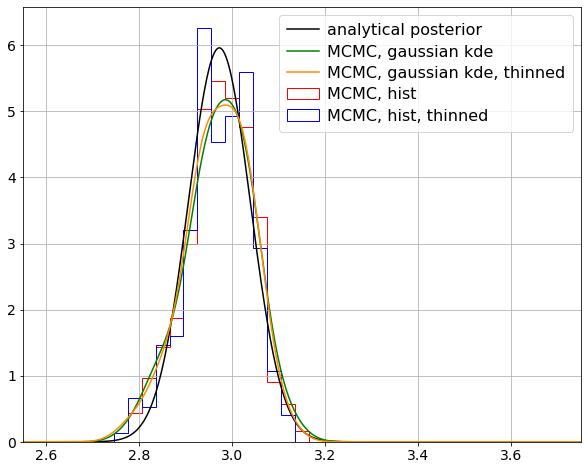

In [32]:
samples = Y[1000:]

plt.figure(figsize=(10, 8))

x_p = np.linspace(0.75*true_mu, 1.25*true_mu, 1000)
plt.plot(x_p, analytical_posterior_pdf(x_p, X, true_std, prior_mu, prior_std), 'k-', label='analytical posterior')

bandwidth = 0.03
plt.hist(*hist_wrapper(samples, bandwidth), density=True, edgecolor='r', histtype = 'step', label='MCMC, hist')
plt.hist(*hist_wrapper(samples[::4], bandwidth), density=True, edgecolor='b', histtype = 'step', label='MCMC, hist, thinned')

plt.plot(*gaussian_kde_wrapper(samples, bandwidth), 'g', label='MCMC, gaussian kde')
plt.plot(*gaussian_kde_wrapper(samples[::4], bandwidth), 'darkorange', label='MCMC, gaussian kde, thinned')

plt.grid()
plt.legend(loc = 'upper right')
plt.xlim(0.85*true_mu, 1.25*true_mu)
plt.show()

#All obtained distributions (including analytical!) are very similar to each other. The thinning (decorrelation) has no visible effect.

#In this case, I use a fixed bandwidth, because the numerical risk optimization procedure of bandwidth (h) 
# gives too small values without much risk gain, which are "hard to perceive by eyes". But the code for this lies in the cell above.

### Task 3.5: Posterior predictive distribution (1 bonus point)

Now that we have obtained the estimate of the posterior, we can turn to a more practical task: predicting new values $X_{n+1}$. To do it in a Bayesian fashion, we employ posterior predictive distribution:
$$p(X_{n+1} | \boldsymbol{X}^{(n)}) = \int p(X_{n+1}, \mu | \boldsymbol{X}^{(n)}) d \mu = \int p(X_{n+1} | \mu, \boldsymbol{X}^{(n)}) p(\mu | \boldsymbol{X}^{(n)})d \mu = \int p(X_{n+1} | \mu) p(\mu | \boldsymbol{X}^{(n)})d \mu$$

Similar to part 1, for our simple model this distribution can also be derived analyticaly and is described on the same Wiki page.

1. Implement analytical posterior predictive distribution for our model and plot it
2. Using decorrelated samples from the posterior, obtained in the previous part, approximate the posterior predictive distribution (with histogram or KDE) and add it to the plot. Is it close to the analytical result?

Posterior predictive hyperparameters (of a new data point $X_{n+1}$ given the observed data points) are as follows:
$$
\mu_{pp} = \mu_p
\quad \& \quad
\sigma_{pp}^2 = \left(\sigma_p^2 + \sigma^2\right).
$$

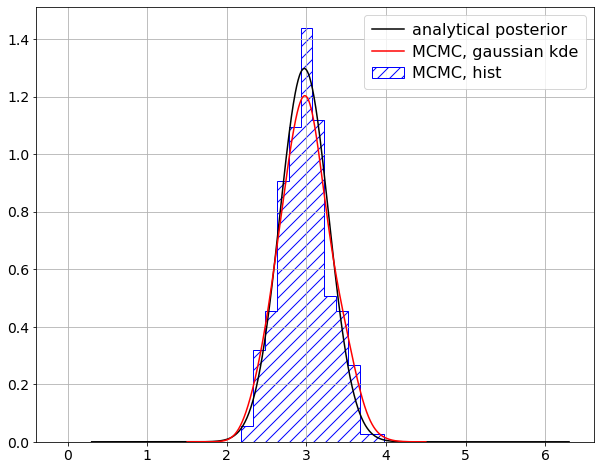

In [33]:
def analytical_predictive_posterior_pdf(x, samples, sigma, mu_0, sigma_0):
    
    sigma_p = np.sqrt((1./sigma_0**2 + samples.size/sigma**2)**(-1))
    mu_p = (mu_0/sigma_0**2 + np.sum(samples)/sigma**2) * sigma_p**2
    
    # then...
    mu_pp = mu_p
    sigma_pp = np.sqrt(sigma_p**2 + sigma**2)
    
    return scipy.stats.norm(mu_pp, sigma_pp).pdf(x)

x_p = np.linspace(0.1*true_mu, 2.1*true_mu, 1000)

plt.figure(figsize=(10, 8))
plt.plot(x_p, analytical_predictive_posterior_pdf(x_p, X, true_std, prior_mu, prior_std), 'k-', label='analytical posterior')

bandwidth = 0.15
predictions = np.random.normal(samples[::4], true_std, )

plt.hist(*hist_wrapper(predictions, bandwidth), color='b', density=True, histtype = 'step', hatch='//', label='MCMC, hist')
plt.plot(*gaussian_kde_wrapper(predictions, bandwidth), color='r', label='MCMC, gaussian kde')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

# Again, all obtained distributions (including analytical!) are very similar to each other.
# In the end, we are convinced that the bayesian inference with MCMC is good mechanism for predicting the distribution.